In [19]:
from zipfile import ZipFile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import tensorflow
import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3, VGG19
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
df = pd.read_csv('drive/Shareddrives/Machine Learning Project/UTK_Face0521.csv')

In [22]:
df = df.drop(['img_name','ethnicity'], axis=1)

In [23]:
def class_labels(age):
    if 0 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 < age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [24]:
df['target'] = df['age'].map(class_labels)
y = df['target']
X = df['pixels']

In [25]:
X = X.apply(lambda x: x.split(' '))
X = X.apply(lambda x: np.array(list(map(lambda z: np.float(z), x))))
X = np.array(X)
X = np.stack(np.array(X), axis=0)
X = np.reshape(X, (-1, 48, 48))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [27]:
num_classes = 7
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print(X_train.shape)
print(y_train.shape)

(16593, 48, 48)
(16593, 7)


In [28]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [29]:
#data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

datagen.fit(X_train)


In [30]:
model2 = Sequential([
    Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(48,48,1)),
    MaxPooling2D(2,2), 
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(num_classes,activation='softmax')
])

model2.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 64)        

In [31]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

In [32]:
model2_history = model2.fit(X_train, y_train, 
                            batch_size=128, 
                            epochs=60,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping_cb])

Epoch 1/60
130/130 [==============================] - 46s 349ms/step - loss: 1.6881 - accuracy: 0.3223 - val_loss: 1.5489 - val_accuracy: 0.3684
Epoch 2/60
130/130 [==============================] - 43s 330ms/step - loss: 1.4236 - accuracy: 0.4102 - val_loss: 1.2865 - val_accuracy: 0.4672
Epoch 3/60
130/130 [==============================] - 43s 330ms/step - loss: 1.2481 - accuracy: 0.4769 - val_loss: 1.2094 - val_accuracy: 0.4871
Epoch 4/60
130/130 [==============================] - 43s 330ms/step - loss: 1.1639 - accuracy: 0.5125 - val_loss: 1.1426 - val_accuracy: 0.5264
Epoch 5/60
130/130 [==============================] - 43s 330ms/step - loss: 1.1017 - accuracy: 0.5353 - val_loss: 1.1296 - val_accuracy: 0.5174
Epoch 6/60
130/130 [==============================] - 43s 332ms/step - loss: 1.0455 - accuracy: 0.5622 - val_loss: 1.1420 - val_accuracy: 0.5298
Epoch 7/60
130/130 [==============================] - 43s 335ms/step - loss: 1.0085 - accuracy: 0.5796 - val_loss: 1.0808 - val_ac

In [33]:
import plotly.express as px
fig = px.line(
    model2_history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Age Model"
)

fig.show()

In [34]:
loss, acc = model2.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 1.0261563062667847
Test Accuracy: 0.5688976645469666


In [35]:
y_pred_train = model2.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)
y_train = np.argmax(y_train, axis=1)
accuracy_score(y_train, y_pred_train)

0.6740794310853975

In [36]:
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       465
           1       0.61      0.64      0.62       426
           2       0.45      0.27      0.33       539
           3       0.51      0.54      0.53      1564
           4       0.54      0.68      0.61      2309
           5       0.57      0.50      0.53      1189
           6       0.73      0.35      0.47       620

    accuracy                           0.57      7112
   macro avg       0.61      0.55      0.56      7112
weighted avg       0.58      0.57      0.56      7112



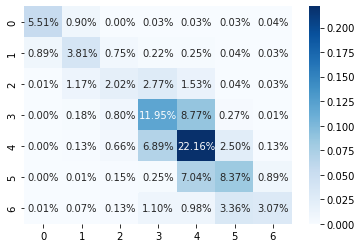

In [37]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

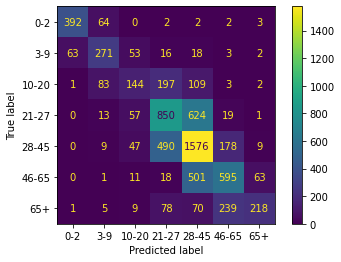

In [38]:
cmd_obj = ConfusionMatrixDisplay(cf_matrix, display_labels=['0-2', '3-9', '10-20', '21-27', '28-45','46-65', '65+'])
cmd_obj.plot()